In [15]:
import numpy as np
import matplotlib.pyplot as plt
from GWFish import detection
import h5py
import math
import astropy.constants  as const
from astropy.cosmology  import Planck18
from GWFish.modules     import utilities as util
from astropy.coordinates import Distance
from astropy import units as u
import multiprocessing as mp
from itertools import product


plt.rcParams.update({'font.size': 13})

In [16]:
import GWFish.modules as gw

def _fd_phase_correction_and_output_format_from_stain_series(f_, hp, hc, geo_time = 1395964818):
    '''
    Prepares the polarizations for GWFish projection function. Combining 
    the functions "_fd_phase_correction_geocent_time", "_fd_gwfish_output_format" as in LALFD_Waveform class from waveforms.py module.

    Parameters
    ----------
    f_ : array
        Frequency array
    hp : array
        Plus polarization
    hc : array
        Cross polarization
    geo_time : int, optional
        Geocentric time
    
    Returns
    -------
    array
        Polarizations in form (hp, hc)
    '''
    phi_in = np.exp( 1.j * (2 * f_ * np.pi * geo_time) ).T[0]
    fft_dat_plus  = phi_in*np.conjugate( hp )
    fft_dat_cross = phi_in*np.conjugate( hc )

    # GW Fish format for hfp and hfc
    hfp = fft_dat_plus[:, np.newaxis]
    hfc = fft_dat_cross[:, np.newaxis]
    polarizations = np.hstack((hfp, hfc))

    return polarizations

def get_SNR_from_series(f_in, hp, hc, network, parameters, geo_time = 1395964818, long_wavelength_approx = False):

    '''
    Given a set of parameters, polarizations, network, timevector and frequency array, returns the SNR associated to the signal

    Parameters
    ----------
    f_in : array
        Frequency array on which to evaluate the signal
    hp : array
        Plus polarization without geocentric time phase corrections
    hc : array
        Cross polarization without geocentric time phase corrections
    network : gw.detection.DetectorNetwork
        Detector Network object
    params : dict
        Parameters of the event, needs to include ra, dec, psi
    geo_time : int, optional
        Geocentric time
    long_wavelength_approx : bool, optional
        Whether to use the long wavelength approximation or not

    Returns
    -------
    float
        Total signal-to-Noise Ratio 
    '''
        
    polarizations = _fd_phase_correction_and_output_format_from_stain_series(f_in, hp, hc)   
    timevector = np.ones( len(f_in) ) * geo_time

    series_data = (polarizations, timevector, f_in)

    polarizations, timevector, f_new = series_data

    snrs_series = {}
    for detector in network.detectors:
        detector.frequencyvector = f_new
        args = (parameters, detector, polarizations, timevector)
        signal = gw.detection.projection(*args, long_wavelength_approx = long_wavelength_approx)
        component_SNRs = gw.detection.SNR(detector, signal, frequencyvector=np.squeeze(f_new))
        out_SNR = np.sqrt(np.sum(component_SNRs**2))
        snrs_series[detector.name] = out_SNR

    out_SNR = np.sqrt(np.sum([snrs_series[detector.name]**2 for detector in network.detectors]))
    return out_SNR

In [17]:
network_data = [
    (['ETS_15', 'ETN_15'], "ET(2L)"),
    (['ETS_15', 'ETN_15', 'CE2'], "ET(2L) + CE40km"),
    (['ETS_15', 'ETN_15', 'CE2', 'CE1'], "ET(2L) + CE40km + CE20km"),
    (['ET', 'CE2'], "ET(Δ) + CE40km"),
    (['ET', 'CE2', 'CE1'], "ET(Δ) + CE40km + CE20km"),
    (['ETS_15', 'ETN_15', 'LLO', 'LHO', 'VIR', 'CE2', 'CE1', 'KAG'], "ET(2L) + CE40km + CE20km + LVK"),
    (['ET', 'LLO', 'LHO', 'VIR', 'CE2', 'CE1', 'KAG'], "ET(Δ) + CE40km + CE20km + LVK"),
    (['LLO', 'LHO', 'VIR', 'KAG'], "LVK")
]

networks = [
    {"network": detection.Network(detector_ids=detector_ids), "label": label}
    for detector_ids, label in network_data
]

network_1, network_2, network_3, network_4, network_5, network_6, network_7, network_8 = networks

In [18]:
from concurrent.futures import ThreadPoolExecutor

dist    = 40 # Mpc
z       = Distance(dist, u.kpc).z

const_corr = const.kpc.value / const.c.value * 1e3 * dist / 4.925e-6

filename = "nonlinearfit_data_FD.hdf5" 

network_in = network_5["network"] # triangle + CE40km + CE20km
print("Network: ", network_5["label"])

params = {
    "ra"        : np.random.uniform(0., 2 * np.pi),
    "dec"       : np.arcsin(np.random.uniform(-1, 1)),
    "psi"       : np.pi*0.3,
    'geocent_time': 1395964818,
}
long_wavelength_approx_flag = False

def snr_func( f_in , hp_f, hc_f, network, params, ra, dec, iota, long_wavelength_approx):
    hc_f_in = hc_f * np.sqrt(5/4/np.pi) * np.sin(iota)
    hp_f_in = hp_f * np.sqrt(5/4/np.pi) * (1 + np.cos(iota)**2) / 2
    params["ra"]    = ra # set the right ascension
    params["dec"]   = dec # set the declination
    out_SNR         = get_SNR_from_series(f_in, hp_f_in, hc_f_in, network, params, long_wavelength_approx=long_wavelength_approx)
    return iota, ra, dec, out_SNR # out_SNR should already be a float

def process_signal_data(freq, hfc, hfp, z, const_corr, f_min = 4000, f_max = 10_000):
    # Redshift the frequency and apply the constant correction
    f_in = np.array(freq / (1 + z))
    hc_f = hfc / const_corr 
    hp_f = hfp / const_corr 
    cond = (f_in >= f_min) & (f_in <= f_max)
    return f_in[cond][:, None], hc_f[cond], hp_f[cond]

def generate_args_list(f_in, hp_f, hc_f, network, params, long_wavelength_approx = False, n_points = 400, n_iota = 6):
    # Generate random angles and combine them to prepare the arguments for snr_func
    ra      = np.random.uniform(0., 2 * np.pi, n_points)
    dec     = np.arcsin(np.random.uniform(-1, 1, n_points))
    iota    = np.arccos(np.random.uniform(-1, 1, n_iota))

    ra_dec = list(zip(ra, dec))
    # Create argument combinations: for each (ra, dec) and each iota
    args_list = [
        (f_in, hp_f, hc_f, network, params, ra_val, dec_val, iota_val, long_wavelength_approx)
        for iota_val, (ra_val, dec_val) in product(iota, ra_dec)
    ]
    return args_list

def process_group_item(k, val, network, params, z, const_corr, long_wavelength_approx, frequency_range = (4000, 10_000)):
    if 'frequency_domain' in val.keys():
        hfc, freq, hfp = val["frequency_domain"].values()
    else : 
        freq, hfc, hfp      = val.values()
    f_in, hc_f, hp_f    = process_signal_data(freq, hfc, hfp, z, const_corr, f_min = frequency_range[0], f_max = frequency_range[1])
    args_list           = generate_args_list(f_in, hp_f, hc_f, network, params, long_wavelength_approx)

    cores = mp.cpu_count()
    with ThreadPoolExecutor(max_workers=cores) as executor:
        futures = [executor.submit(snr_func, *args) for args in args_list]
        snr_sub = [f.result() for f in futures]

    #print(f'Finished {k}')
    return snr_sub

results_dict = {}

with h5py.File(filename) as g:
    for k, val in g.items():
        results_dict[k] = process_group_item(k, val, network_in, params, z, const_corr, long_wavelength_approx=long_wavelength_approx_flag)

Network:  ET(Δ) + CE40km + CE20km


In [5]:
# Create a list of tuples (key, median value) and sort it by the median value
sorted_results = sorted(
    ((key, np.median(np.array(result).T[3])) for key, result in results_dict.items()),
    key=lambda x: x[1]
)

# Print sorted results
for key, median in sorted_results:
    print(f"{key:<30}: {median:<10.2f}")

EOSBHB_M1065-1775_LR_MF       : 0.37      
EOSBHB_M1069-1781_SR_MF       : 0.63      
EOSLS220_M1138-1752_LR_MF     : 0.77      
EOSSFHo_M1031-1719_SR_MF      : 0.86      
EOSLS220_M1278-1704_SR_MF     : 1.17      
EOSDD2_M1189-1981_SR_MF       : 1.27      
EOSLS220_M1272-1697_SR_MF     : 1.30      
EOSBHB_M1223-1747_SR_MF       : 1.47      
EOSSFHo_M1309-1541_SR_MF      : 1.50      
EOSLS220_M1204-1720_SR_MF     : 1.53      
EOSDD2_M1273-1957_SR_MF       : 1.53      
EOSDD2qG_M1587-1587_SR_MF     : 1.56      
EOSSFHo_M1217-1623_SR_MF      : 1.57      
EOSSFHo_M1305-1535_SR_MF      : 1.60      
EOSLS220_M1269-1691_SR_MF     : 1.63      
EOSDD2_M1351-1929_SR_MF       : 1.68      
EOSBHB_M1401-1649_LR_MF       : 1.79      
EOSDD2_M1355-1935_SR_MF       : 1.86      
EOSLS220_M1365-1605_SR_MF     : 1.98      
EOSDD2qG_M1458-1716_SR_MF     : 2.09      
EOSBHB_M1286-1714_SR_MF       : 2.18      
EOSDD2_M1516-1784_SR_MF       : 2.24      
EOSDD2_M1512-1778_SR_MF       : 2.41      
EOSDD2_M141

In [6]:
network_in = network_3["network"] # 2L + CE40km + CE20km
print("Network: ", network_3["label"])

results_dict_2L = {}

with h5py.File(filename) as g:
    for k, val in g.items():
        results_dict_2L[k] = process_group_item(k, val, network_in, params, z, const_corr, long_wavelength_approx=long_wavelength_approx_flag)

Network:  ET(2L) + CE40km + CE20km


In [7]:
# Create a list of tuples (key, median value) and sort it by the median value
sorted_results_2L = sorted(
    ((key, np.median(np.array(result).T[3])) for key, result in results_dict_2L.items()),
    key=lambda x: x[1]
)

# Print sorted results
for key, median in sorted_results_2L:
    print(f"{key:<30}: {median:<10.2f}")

EOSBHB_M1065-1775_LR_MF       : 0.35      
EOSBHB_M1069-1781_SR_MF       : 0.62      
EOSLS220_M1138-1752_LR_MF     : 0.68      
EOSSFHo_M1031-1719_SR_MF      : 0.78      
EOSLS220_M1278-1704_SR_MF     : 1.05      
EOSDD2_M1189-1981_SR_MF       : 1.15      
EOSLS220_M1272-1697_SR_MF     : 1.26      
EOSLS220_M1204-1720_SR_MF     : 1.30      
EOSSFHo_M1309-1541_SR_MF      : 1.33      
EOSDD2qG_M1587-1587_SR_MF     : 1.35      
EOSSFHo_M1305-1535_SR_MF      : 1.35      
EOSSFHo_M1217-1623_SR_MF      : 1.36      
EOSBHB_M1223-1747_SR_MF       : 1.37      
EOSDD2_M1273-1957_SR_MF       : 1.48      
EOSDD2_M1351-1929_SR_MF       : 1.53      
EOSLS220_M1269-1691_SR_MF     : 1.57      
EOSBHB_M1401-1649_LR_MF       : 1.68      
EOSDD2_M1355-1935_SR_MF       : 1.69      
EOSLS220_M1365-1605_SR_MF     : 1.80      
EOSDD2qG_M1458-1716_SR_MF     : 1.87      
EOSDD2_M1516-1784_SR_MF       : 2.10      
EOSBHB_M1286-1714_SR_MF       : 2.10      
EOSDD2_M1512-1778_SR_MF       : 2.13      
EOSDD2_M141

In [8]:
#compare results_dict_2L to results_dict
for key, result in results_dict.items():
    data_snr = np.array(result).T[3]
    median = np.median(data_snr)
    #check if key exists 
    if key not in results_dict_2L:
        print(f"{key}: ($\Delta$) {median=:.2f} -> (2L) -")
        continue
    data_snr_2L = np.array(results_dict_2L[key]).T[3]
    median_2L = np.median(data_snr_2L)
    print(f"{key}: ($\Delta$) {median=:.2f} -> (2L) {median_2L=:.2f} ({100*(1-median/median_2L):.2f}%)")

EOSBHB_M1065-1775_LR_MF: ($\Delta$) median=0.37 -> (2L) median_2L=0.35 (-6.70%)
EOSBHB_M1069-1781_SR_MF: ($\Delta$) median=0.63 -> (2L) median_2L=0.62 (-1.89%)
EOSBHB_M1223-1747_SR_MF: ($\Delta$) median=1.47 -> (2L) median_2L=1.37 (-6.78%)
EOSBHB_M1286-1714_SR_MF: ($\Delta$) median=2.18 -> (2L) median_2L=2.10 (-3.56%)
EOSBHB_M1397-1643_SR_MF: ($\Delta$) median=2.73 -> (2L) median_2L=2.39 (-14.12%)
EOSBHB_M1401-1649_LR_MF: ($\Delta$) median=1.79 -> (2L) median_2L=1.68 (-6.72%)
EOSDD2_M1189-1981_SR_MF: ($\Delta$) median=1.27 -> (2L) median_2L=1.15 (-10.24%)
EOSDD2_M1273-1957_SR_MF: ($\Delta$) median=1.53 -> (2L) median_2L=1.48 (-3.41%)
EOSDD2_M1351-1929_SR_MF: ($\Delta$) median=1.68 -> (2L) median_2L=1.53 (-9.88%)
EOSDD2_M1355-1935_SR_MF: ($\Delta$) median=1.86 -> (2L) median_2L=1.69 (-9.92%)
EOSDD2_M1410-1880_SR_MF: ($\Delta$) median=2.42 -> (2L) median_2L=2.32 (-4.35%)
EOSDD2_M1512-1778_SR_MF: ($\Delta$) median=2.41 -> (2L) median_2L=2.13 (-13.29%)
EOSDD2_M1516-1784_SR_MF: ($\Delta$) m

In [ ]:
filenames_to_check = [
    "spectrum_data.hdf5",
    "nonlinearfit_data_FD.hdf5"
]

high_frequency_flags = [
    False,
    True
]

frequency_ranges = [
    (4000, 10_000),
    (3000, 10_000)
]

networks = [
    network_5,
    network_3
]

In [ ]:
import pandas as pd

#iterate over the product and get the results, save them in a dictionary 
all_results = {}
args_list_test = product(filenames_to_check, high_frequency_flags, frequency_ranges, networks)
# make a key / value pair for each combination of parameters
# put the keys as the keys of all_results 
k_v_pair = [(f"{filename}_{high_frequency_flag}_{frequency_range}_{network['label']}", 
             (filename, high_frequency_flag, frequency_range, network)) for filename, high_frequency_flag, frequency_range, network in args_list_test]

#make the product of all the parameters
args_list = product(filenames_to_check, high_frequency_flags, frequency_ranges, networks)

results = {}
for filename, high_frequency_flag, frequency_range, network in args_list:
    network_in = network["network"]
    with h5py.File(filename) as g:
        for k, val in g.items():
            results[k] = process_group_item(k, val, network_in, params, z, const_corr, long_wavelength_approx=high_frequency_flag, frequency_range = frequency_range)
    
    # Create a list of tuples (key, median value, 5th percentile, 95th percentile) and sort it by the median value
    sorted_results = sorted(
        (
            (
                key,
                np.median(np.array(result).T[3]),
                np.percentile(np.array(result).T[3], 5),
                np.percentile(np.array(result).T[3], 95)
            )
            for key, result in results.items()
        ),
        key=lambda x: x[1]
    )

    # Create a pandas DataFrame from sorted_results and display it
    df_results = pd.DataFrame(
        sorted_results,
        columns=['Name', 'Median', '5th Percentile', '95th Percentile']
    )
    all_results[f"{filename}_{high_frequency_flag}_{frequency_range}_{network['label']}"] = df_results

    print(f"Filename: {filename}, LW Approximation: {high_frequency_flag}, Frequency range: {frequency_range}, Network: {network['label']}")
    display(df_results)

Filename: spectrum_data.hdf5, LW Approximation: False, Frequency range: (4000, 10000), Network: ET(Δ) + CE40km + CE20km


,Name,Median,5th Percentile,95th Percentile
0,EOSBHB_M1065-1775_LR_MF,0.362593,0.205906,0.604981
1,EOSBHB_M1069-1781_SR_MF,0.578000,0.329753,0.881322
2,EOSLS220_M1138-1752_LR_MF,0.785137,0.453432,1.285829
3,EOSDD2_M1273-1957_SR_MF,1.376892,0.786398,2.432981
4,EOSLS220_M1278-1704_SR_MF,1.420067,0.798301,2.156447
5,EOSLS220_M1204-1720_SR_MF,1.452960,0.860255,2.267545
6,EOSBHB_M1223-1747_SR_MF,1.569530,0.899182,2.496459
7,EOSLS220_M1272-1697_SR_MF,1.702787,0.974970,2.842737
8,EOSSFHo_M1200-1600_LR_MF,1.768472,1.031332,2.735886
9,EOSLS220_M1269-1691_SR_MF,1.782399,0.985904,2.884550


Filename: spectrum_data.hdf5, LW Approximation: False, Frequency range: (4000, 10000), Network: ET(2L) + CE40km + CE20km


,Name,Median,5th Percentile,95th Percentile
0,EOSBHB_M1065-1775_LR_MF,0.347201,0.189413,0.583681
1,EOSBHB_M1069-1781_SR_MF,0.538093,0.277416,0.870572
2,EOSLS220_M1138-1752_LR_MF,0.748131,0.417794,1.233034
3,EOSLS220_M1278-1704_SR_MF,1.319513,0.755420,2.167710
4,EOSLS220_M1204-1720_SR_MF,1.369830,0.756131,2.409590
5,EOSDD2_M1273-1957_SR_MF,1.378934,0.737520,2.279319
6,EOSBHB_M1223-1747_SR_MF,1.427700,0.797699,2.342781
7,EOSLS220_M1269-1691_SR_MF,1.581334,0.849022,2.668415
8,EOSLS220_M1272-1697_SR_MF,1.636534,0.907335,2.574667
9,EOSSFHo_M1200-1600_LR_MF,1.671148,0.958349,2.841763


Filename: spectrum_data.hdf5, LW Approximation: False, Frequency range: (3000, 10000), Network: ET(Δ) + CE40km + CE20km


,Name,Median,5th Percentile,95th Percentile
0,EOSBHB_M1065-1775_LR_MF,0.953973,0.614346,1.326691
1,EOSLS220_M1138-1752_LR_MF,1.183123,0.716558,1.748818
2,EOSBHB_M1069-1781_SR_MF,1.359568,0.860642,1.887001
3,EOSLS220_M1278-1704_SR_MF,2.217410,1.313291,3.683517
4,EOSLS220_M1204-1720_SR_MF,2.242106,1.402135,3.450640
5,EOSLS220_M1272-1697_SR_MF,2.704677,1.565490,3.985255
6,EOSLS220_M1269-1691_SR_MF,2.734365,1.698675,4.296195
7,EOSDD2_M1273-1957_SR_MF,2.775035,1.658306,4.281126
8,EOSSFHo_M1217-1623_SR_MF,2.888557,1.736576,4.804627
9,EOSBHB_M1223-1747_SR_MF,2.918007,1.787090,4.434377


Filename: spectrum_data.hdf5, LW Approximation: False, Frequency range: (3000, 10000), Network: ET(2L) + CE40km + CE20km


,Name,Median,5th Percentile,95th Percentile
0,EOSBHB_M1065-1775_LR_MF,0.886177,0.564603,1.283139
1,EOSLS220_M1138-1752_LR_MF,1.111682,0.680018,1.647351
2,EOSBHB_M1069-1781_SR_MF,1.238392,0.807641,1.868503
3,EOSLS220_M1278-1704_SR_MF,2.040473,1.271725,3.217993
4,EOSLS220_M1204-1720_SR_MF,2.136857,1.319910,3.603747
5,EOSLS220_M1272-1697_SR_MF,2.438175,1.546327,3.892097
6,EOSLS220_M1269-1691_SR_MF,2.601483,1.611777,3.874926
7,EOSDD2_M1273-1957_SR_MF,2.667753,1.641540,4.166765
8,EOSSFHo_M1217-1623_SR_MF,2.749241,1.653034,4.291699
9,EOSSFHo_M1309-1541_SR_MF,2.768735,1.728033,4.559505


Filename: spectrum_data.hdf5, LW Approximation: True, Frequency range: (4000, 10000), Network: ET(Δ) + CE40km + CE20km


,Name,Median,5th Percentile,95th Percentile
0,EOSBHB_M1065-1775_LR_MF,1.141597,0.459243,2.035034
1,EOSBHB_M1069-1781_SR_MF,1.825635,0.892127,3.101373
2,EOSLS220_M1138-1752_LR_MF,2.610329,1.076251,4.664517
3,EOSLS220_M1278-1704_SR_MF,4.369745,1.775622,8.101683
4,EOSDD2_M1273-1957_SR_MF,4.626203,1.899426,8.517506
5,EOSLS220_M1204-1720_SR_MF,4.638967,2.213451,7.835940
6,EOSBHB_M1223-1747_SR_MF,5.142700,2.161521,9.321983
7,EOSSFHo_M1200-1600_LR_MF,5.540926,2.553062,9.153103
8,EOSLS220_M1272-1697_SR_MF,5.542965,2.428996,9.255314
9,EOSDD2_M1355-1935_SR_MF,5.580634,2.702136,10.188864


Filename: spectrum_data.hdf5, LW Approximation: True, Frequency range: (4000, 10000), Network: ET(2L) + CE40km + CE20km


,Name,Median,5th Percentile,95th Percentile
0,EOSBHB_M1065-1775_LR_MF,1.153087,0.465872,2.007223
1,EOSBHB_M1069-1781_SR_MF,1.777454,0.784666,3.083740
2,EOSLS220_M1138-1752_LR_MF,2.438722,1.158623,4.891469
3,EOSLS220_M1278-1704_SR_MF,4.307116,1.591364,7.452428
4,EOSLS220_M1204-1720_SR_MF,4.678503,2.211255,8.227592
5,EOSDD2_M1273-1957_SR_MF,4.859286,1.986694,8.587874
6,EOSBHB_M1223-1747_SR_MF,5.178298,1.743285,9.140108
7,EOSSFHo_M1200-1600_LR_MF,5.363515,2.093215,9.584791
8,EOSLS220_M1269-1691_SR_MF,5.541716,2.095621,9.726896
9,EOSDD2_M1355-1935_SR_MF,5.590041,2.434855,10.266529


Filename: spectrum_data.hdf5, LW Approximation: True, Frequency range: (3000, 10000), Network: ET(Δ) + CE40km + CE20km


,Name,Median,5th Percentile,95th Percentile
0,EOSBHB_M1065-1775_LR_MF,2.832289,1.235525,4.975572
1,EOSLS220_M1138-1752_LR_MF,3.866770,1.591920,6.915165
2,EOSBHB_M1069-1781_SR_MF,4.096300,1.760778,7.296255
3,EOSLS220_M1278-1704_SR_MF,7.439151,3.148651,13.519181
4,EOSLS220_M1204-1720_SR_MF,7.619163,3.191220,13.703728
5,EOSLS220_M1272-1697_SR_MF,8.895055,3.811553,15.477491
6,EOSLS220_M1269-1691_SR_MF,9.021878,3.937483,16.102110
7,EOSDD2_M1273-1957_SR_MF,9.241354,4.350428,16.369778
8,EOSBHB_M1223-1747_SR_MF,9.477358,4.029588,16.593002
9,EOSSFHo_M1217-1623_SR_MF,9.921060,3.979250,16.279125


Filename: spectrum_data.hdf5, LW Approximation: True, Frequency range: (3000, 10000), Network: ET(2L) + CE40km + CE20km


,Name,Median,5th Percentile,95th Percentile
0,EOSBHB_M1065-1775_LR_MF,2.849116,1.261525,5.017649
1,EOSLS220_M1138-1752_LR_MF,3.864388,1.492246,6.684762
2,EOSBHB_M1069-1781_SR_MF,4.032708,1.617079,7.206813
3,EOSLS220_M1204-1720_SR_MF,7.321939,3.258035,12.868281
4,EOSLS220_M1278-1704_SR_MF,7.586957,2.942106,13.197635
5,EOSLS220_M1272-1697_SR_MF,8.562968,3.688742,14.731164
6,EOSLS220_M1269-1691_SR_MF,8.843903,3.926158,16.120524
7,EOSDD2_M1273-1957_SR_MF,8.964137,3.489315,15.083190
8,EOSBHB_M1223-1747_SR_MF,9.449463,3.662382,16.941940
9,EOSSFHo_M1309-1541_SR_MF,9.801101,4.414984,17.706035


Filename: nonlinearfit_data_FD.hdf5, LW Approximation: False, Frequency range: (4000, 10000), Network: ET(Δ) + CE40km + CE20km


,Name,Median,5th Percentile,95th Percentile
0,EOSBHB_M1065-1775_LR_MF,0.373446,0.216414,0.600498
1,EOSBHB_M1069-1781_SR_MF,0.642625,0.363516,1.063944
2,EOSLS220_M1138-1752_LR_MF,0.784993,0.449902,1.155278
3,EOSSFHo_M1031-1719_SR_MF,0.870963,0.505950,1.401458
4,EOSLS220_M1278-1704_SR_MF,1.185547,0.699689,1.825183
5,EOSDD2_M1189-1981_SR_MF,1.213198,0.716643,2.031870
6,EOSLS220_M1272-1697_SR_MF,1.297723,0.780708,1.856422
7,EOSBHB_M1223-1747_SR_MF,1.424528,0.861291,2.266956
8,EOSDD2_M1273-1957_SR_MF,1.468771,0.833404,2.321276
9,EOSSFHo_M1309-1541_SR_MF,1.473759,0.918447,2.123814


Filename: nonlinearfit_data_FD.hdf5, LW Approximation: False, Frequency range: (4000, 10000), Network: ET(2L) + CE40km + CE20km


,Name,Median,5th Percentile,95th Percentile
0,EOSBHB_M1065-1775_LR_MF,0.349300,0.198033,0.551061
1,EOSBHB_M1069-1781_SR_MF,0.579347,0.324214,1.004793
2,EOSLS220_M1138-1752_LR_MF,0.695861,0.388860,1.133656
3,EOSSFHo_M1031-1719_SR_MF,0.782652,0.455220,1.273787
4,EOSLS220_M1278-1704_SR_MF,1.113327,0.633524,1.661778
5,EOSDD2_M1189-1981_SR_MF,1.158886,0.603430,1.812743
6,EOSLS220_M1272-1697_SR_MF,1.161023,0.677174,2.049799
7,EOSSFHo_M1309-1541_SR_MF,1.325495,0.791673,2.160127
8,EOSBHB_M1223-1747_SR_MF,1.328053,0.750740,2.242523
9,EOSSFHo_M1305-1535_SR_MF,1.358223,0.795715,2.202121


Filename: nonlinearfit_data_FD.hdf5, LW Approximation: False, Frequency range: (3000, 10000), Network: ET(Δ) + CE40km + CE20km


,Name,Median,5th Percentile,95th Percentile
0,EOSBHB_M1065-1775_LR_MF,0.896396,0.528962,1.427612
1,EOSLS220_M1138-1752_LR_MF,1.016208,0.590906,1.706119
2,EOSSFHo_M1031-1719_SR_MF,1.230378,0.725919,1.830672
3,EOSBHB_M1069-1781_SR_MF,1.298969,0.814030,1.836833
4,EOSLS220_M1278-1704_SR_MF,1.502658,0.871108,2.380053
5,EOSSFHo_M1309-1541_SR_MF,1.738012,1.062001,2.607233
6,EOSSFHo_M1305-1535_SR_MF,1.857567,1.131436,2.769079
7,EOSLS220_M1272-1697_SR_MF,1.868478,1.141904,2.665123
8,EOSSFHo_M1217-1623_SR_MF,1.897173,1.148946,2.988720
9,EOSLS220_M1204-1720_SR_MF,1.927444,1.187410,3.073199


Filename: nonlinearfit_data_FD.hdf5, LW Approximation: False, Frequency range: (3000, 10000), Network: ET(2L) + CE40km + CE20km


,Name,Median,5th Percentile,95th Percentile
0,EOSBHB_M1065-1775_LR_MF,0.822813,0.516333,1.307053
1,EOSLS220_M1138-1752_LR_MF,0.918237,0.534527,1.490696
2,EOSSFHo_M1031-1719_SR_MF,1.065490,0.640006,1.848461
3,EOSBHB_M1069-1781_SR_MF,1.206270,0.737539,1.799543
4,EOSLS220_M1278-1704_SR_MF,1.356895,0.792456,2.109547
5,EOSSFHo_M1309-1541_SR_MF,1.609668,0.906110,2.413653
6,EOSSFHo_M1305-1535_SR_MF,1.656972,0.972604,2.635198
7,EOSSFHo_M1217-1623_SR_MF,1.788266,1.059345,2.782391
8,EOSLS220_M1272-1697_SR_MF,1.816948,1.053299,2.841674
9,EOSLS220_M1269-1691_SR_MF,1.839789,1.107931,3.155180


Filename: nonlinearfit_data_FD.hdf5, LW Approximation: True, Frequency range: (4000, 10000), Network: ET(Δ) + CE40km + CE20km


,Name,Median,5th Percentile,95th Percentile
0,EOSBHB_M1065-1775_LR_MF,1.128152,0.455053,2.018426
1,EOSBHB_M1069-1781_SR_MF,1.951076,0.958965,3.629137
2,EOSLS220_M1138-1752_LR_MF,2.155240,0.940944,3.631360
3,EOSSFHo_M1031-1719_SR_MF,2.577899,1.090778,4.563715
4,EOSLS220_M1278-1704_SR_MF,3.578283,1.583825,6.235267
5,EOSDD2_M1189-1981_SR_MF,3.641261,1.558287,6.687863
6,EOSLS220_M1272-1697_SR_MF,3.657753,1.489396,6.784310
7,EOSDD2qG_M1587-1587_SR_MF,4.059277,2.010299,7.038803
8,EOSBHB_M1223-1747_SR_MF,4.257018,2.177486,7.712252
9,EOSSFHo_M1309-1541_SR_MF,4.265311,2.122721,6.909554


Filename: nonlinearfit_data_FD.hdf5, LW Approximation: True, Frequency range: (4000, 10000), Network: ET(2L) + CE40km + CE20km


,Name,Median,5th Percentile,95th Percentile
0,EOSBHB_M1065-1775_LR_MF,1.179481,0.469315,2.163045
1,EOSBHB_M1069-1781_SR_MF,2.047025,0.937564,3.680038
2,EOSLS220_M1138-1752_LR_MF,2.206897,0.859206,3.933143
3,EOSSFHo_M1031-1719_SR_MF,2.647700,1.288209,4.542075
4,EOSLS220_M1278-1704_SR_MF,3.577200,1.501240,6.507047
5,EOSLS220_M1272-1697_SR_MF,3.705655,1.867292,6.163822
6,EOSDD2_M1189-1981_SR_MF,3.790382,1.711614,6.540274
7,EOSSFHo_M1309-1541_SR_MF,4.156201,1.950926,7.134192
8,EOSDD2qG_M1587-1587_SR_MF,4.167420,1.735234,7.246617
9,EOSSFHo_M1305-1535_SR_MF,4.325398,2.006858,7.566536


Filename: nonlinearfit_data_FD.hdf5, LW Approximation: True, Frequency range: (3000, 10000), Network: ET(Δ) + CE40km + CE20km


,Name,Median,5th Percentile,95th Percentile
0,EOSBHB_M1065-1775_LR_MF,2.858768,1.299866,5.014247
1,EOSLS220_M1138-1752_LR_MF,3.431618,1.486050,5.550735
2,EOSSFHo_M1031-1719_SR_MF,3.980756,1.834827,6.886183
3,EOSBHB_M1069-1781_SR_MF,4.027126,1.777735,7.161690
4,EOSLS220_M1278-1704_SR_MF,4.979601,2.030078,8.402982
5,EOSSFHo_M1309-1541_SR_MF,5.504196,2.540784,9.362628
6,EOSSFHo_M1305-1535_SR_MF,5.581254,2.563568,9.984801
7,EOSSFHo_M1217-1623_SR_MF,6.220027,2.732849,10.564225
8,EOSLS220_M1272-1697_SR_MF,6.224572,2.999428,11.016312
9,EOSLS220_M1204-1720_SR_MF,6.379100,2.947647,11.349463


In [ ]:
#save all the pandas dataframes into a file
with pd.ExcelWriter("all_results.xlsx") as writer:
    for key, df in all_results.items():
        df.to_excel(writer, sheet_name=key)

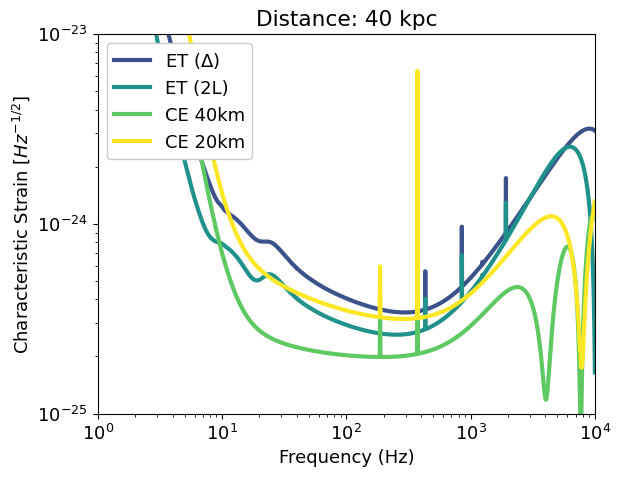

In [ ]:
# compare the strains to the ET psd
from pathlib import Path 

colors = plt.get_cmap('viridis', 5)(np.arange(5))

# Refactored: Get and plot the PSD data using a loop
psd_files = {
    'ET':           ('ET_psd.txt',               colors[1], 'ET ($\\Delta$)'),
    'ET_triangle':  ('ET15kmdata_freq_1_L.txt',  colors[2], 'ET (2L)'),
    'CE40':         ('CE40_psd.txt',             colors[3], 'CE 40km'),
    'CE20':         ('CE20_psd.txt',             colors[4], 'CE 20km')
}

for key, (fname, col, label) in psd_files.items():
    f, psd = np.loadtxt(Path("GWFish/detector_psd") / fname).T
    plt.plot(f, np.sqrt(psd), label=label, linewidth=3, color=col)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Characteristic Strain [$Hz^{-1/2}$]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 1e4)
plt.ylim(1e-25, 1e-23)
plt.legend(loc='upper left', framealpha=1)
plt.tight_layout()
plt.title(f"Distance: {dist:.0f} kpc")
plt.show()